# Procesamiento de Imágenes - Trabajo Práctico N°8
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# Tomografía - GUI

En el presente trabajo se busca realizar una GUI la cual, a partir de imágenes de objetos 2D, obtener su tranformada de Radon y consiguientemente obtener una reconstrucción del objeto original.

La GUI se encuentra al final del archivo.

### Pruebas iniciales

In [1]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon, iradon_sart
from ipywidgets import interact, interact_manual, Dropdown, Output,Layout
from IPython.display import display, clear_output
import glob
from PIL import Image

In [2]:
def plot_radon(img):
    image = rescale(img, scale=0.4, mode='reflect')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

    ax1.set_title("Original")
    ax1.imshow(image, cmap=plt.cm.Greys_r)

    theta = np.linspace(0., 180.,180, endpoint=False)
    sinogram = radon(image, theta=theta)
    dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
    ax2.set_title("Radon transform\n(Sinogram)")
    ax2.set_xlabel("Projection angle (deg)")
    ax2.set_ylabel("Projection position (pixels)")
    ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
            extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
            aspect='auto')

    fig.tight_layout()
    plt.show()

#### Dot

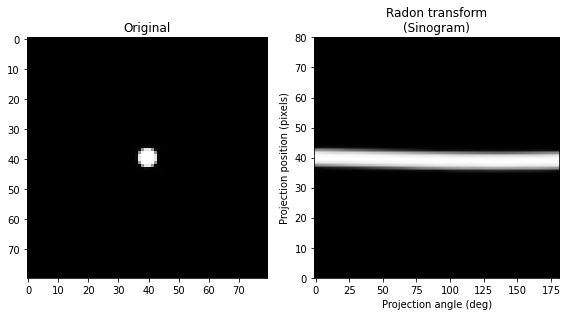

In [3]:
image = np.array(Image.open("test_images/dot.jpg").convert('L'))/255
plot_radon(image)


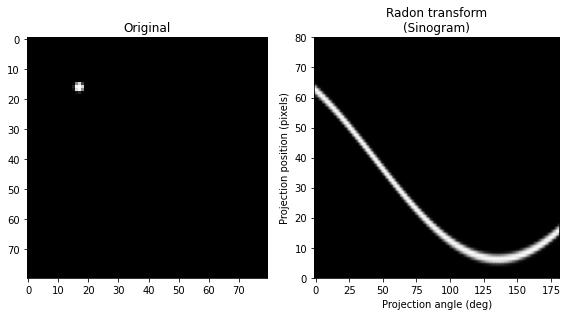

In [4]:
image = np.array(Image.open("test_images/dot_corner.jpg").convert('L'))/255
plot_radon(image)

#### Line

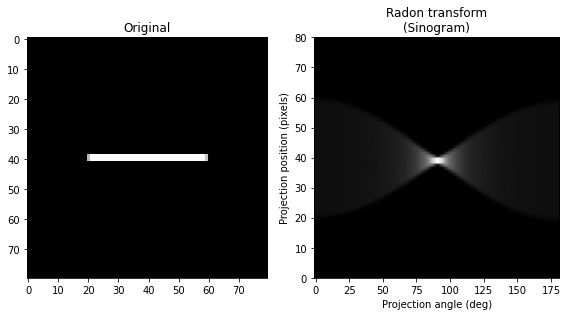

In [5]:
image = np.array(Image.open("test_images/line.jpg").convert('L'))/255
plot_radon(image)

#### Phantom

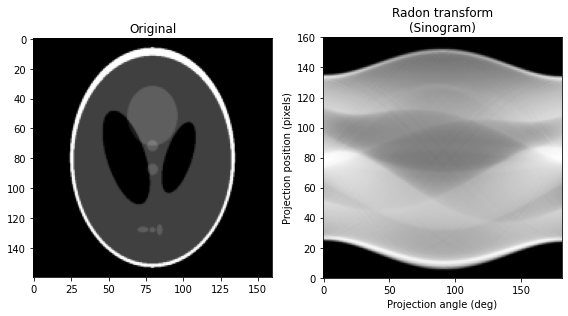

In [6]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180.,180, endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()



FBP rms reconstruction error: 0.0304


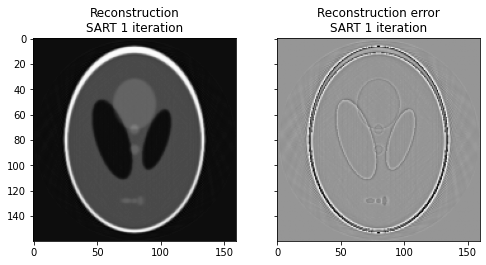

In [7]:
reconstruction_fbp = iradon_sart(sinogram, theta=theta)
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                            sharex=True, sharey=True)
ax1.set_title("Reconstruction\nSART 1 iteration")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nSART 1 iteration")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

In [8]:
reconstruction_fbp = iradon_sart(sinogram, theta=theta)
n_iterations = 5
for i in range(n_iterations):
    reconstruction_fbp = iradon_sart(sinogram, theta=theta, image=reconstruction_fbp)

SART 5 iterations - rms reconstruction error: 0.0143


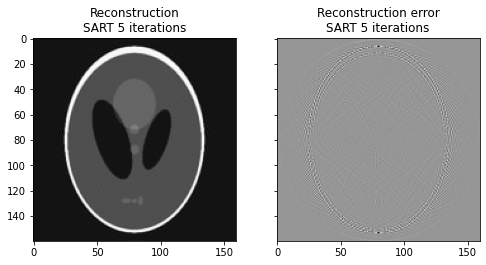

In [9]:
error = reconstruction_fbp - image
print(f'SART {str(n_iterations)} iterations - rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                            sharex=True, sharey=True)
ax1.set_title("Reconstruction\nSART " + str(n_iterations) + " iterations")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nSART "+ str(n_iterations) + " iterations")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

--------------------------------------------------------------------------

### GUI

La interfaz de usuario realizada permite seleccionar una imagen de un objeto 2D almacenada en la carpeta test_images.

#### Carga de imágenes

['test0.png', 'test1.png', 'test2.png', 'dot.jpg', 'dot_corner.jpg', 'line.jpg', 'test3.jpg', 'test4.jpg']


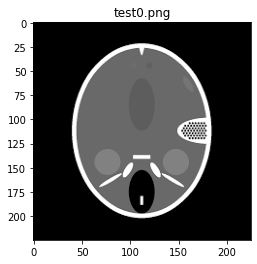

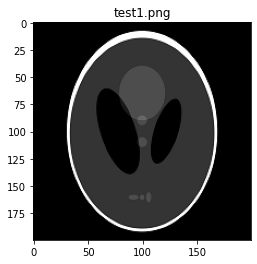

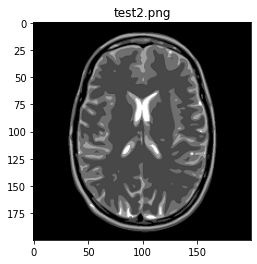

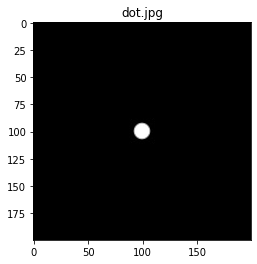

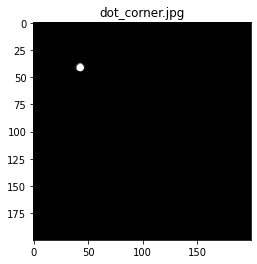

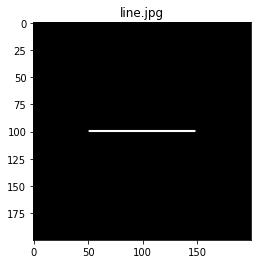

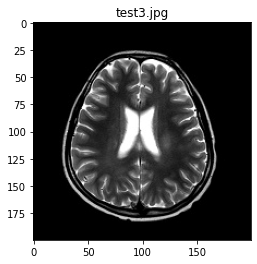

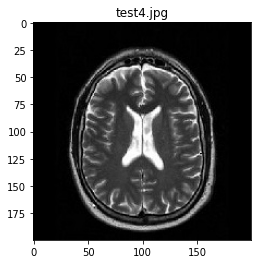

In [10]:
imdir = 'test_images/'
ext = ['png', 'jpg', 'gif', 'tif', 'jpeg']    # Add image formats here

files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]

images = []
for file in files:
    im = np.array(Image.open(file).convert('L'))/255

    images.append(im)
    plt.figure() 
    plt.title(str(file).replace("test_images\\",""))
    plt.imshow(im, cmap="gray")  

files = [str(file).replace("test_images\\","") for file in files]
print(files)

#### Definición de interfaz

In [11]:
from ipywidgets import Button, VBox, IntSlider

items_layout = Layout( width='100%', margin="20px 0 20px 0") 

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='center',
                    align_content='space-around',
                    border='solid',
                    width='95%',
                    padding="10px",
                    margin="20px"
                )

dropdown = Dropdown(
    options=files,
    value=files[0],
    description='Image:',
    active=True,
    disabled=False,
    layout=items_layout
)

preview = Output()

it_slider = IntSlider(
    value=1,
    min=1, max=10., step=1,
    description='Iterations:',
)

angle_slider = IntSlider(
    value=500,
    min=1, max=1000, step=1,
    description='Angle samples:',
)

button = Button(
    description='Run',
    button_style="primary",
    layout=items_layout
)

out = Output()


gui = VBox(children=[dropdown,preview,
                    it_slider,
                    angle_slider,
                    button,
                    out
                    ], layout=box_layout)



In [12]:
@preview.capture()
def on_change(change):
    clear_output(wait=True)
    fig = plt.figure(figsize=(4,4))
    plt.imshow(images[dropdown.index],cmap=plt.cm.Greys_r,)
    plt.title("Selected image")
    plt.show()

@out.capture()
def on_button_clicked(b):
    
    iterations = it_slider.value
    angle_samples = angle_slider.value
    image = images[dropdown.index]

    clear_output(wait=True)

    #### Plot Original ####
    fig = plt.figure(figsize=(25,5))

    axs = fig.add_subplot(141)
    axs.imshow(images[dropdown.index],cmap=plt.cm.Greys_r,)
    axs.set_title("Original")

    ax2 = fig.add_subplot(142)
    ax2.set_title("Loading Radon transform\n(Sinogram)...")
    plt.show()
    
    #### Create radon ####
    theta = np.linspace(0., 180.,angle_samples, endpoint=False)
    sinogram = radon(image, theta=theta)


    dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]

    #### Plot radon ####
    clear_output(wait=True)

    ax2.set_title("Radon transform\n(Sinogram)")
    ax2.set_xlabel("Projection angle (deg)")
    ax2.set_ylabel("Projection position (pixels)")
    ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
            extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
            )
    ax3 = fig.add_subplot(143)
    ax3.set_title("Loading Reconstruction\nSART...")
    display(fig)

    #### Create Reconstruction ####
    reconstruction_fbp = iradon_sart(sinogram, theta=theta)
    for i in range(iterations):
        reconstruction_fbp = iradon_sart(sinogram, theta=theta, image=reconstruction_fbp)

    #### Plot Reconstruction ####
    imkwargs = dict(vmin=-0.2, vmax=0.2)
    clear_output(wait=True)
    ax3.set_title("Reconstruction\nSART")
    ax3.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
    ax3.axis("off")
    ax4 = fig.add_subplot(144)
    ax4.set_title("Loading Reconstruction error\nSART...")
    display(fig)

    #### Plot Reconstruction Error####
    error = reconstruction_fbp - image

    clear_output(wait=True)
    ax4.set_title("Reconstruction error\nSART")
    ax4.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
    ax4.axis("off")
    display(fig)

    print("File: " + str(dropdown.value))
    print("Iterations: " + str(iterations))
    print("Angle samples: " + str(angle_samples))

    print(f'SART rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

button.on_click(on_button_clicked)

dropdown.observe(on_change, names='value')
on_change(None)


## GUI final

In [13]:
gui

En caso de que la gui no se pueda visualizar correctamente en el navegador se deja a continuación una imágen de la gui siendo utilizada para un caso particular.

<div align="center">
    <img src='gui_image/gui.png' alt="gui working" width="75%">
      <h5 align="center">
          Interfaz gráfica de usuario (GUI), funcionando correctamente.
      </h5>
    <br>
</div>